# Capstone - Feature Engineering and Modelling Part II
Date: 2021.11.27<br>
William Matthews

### Report Objectives and Flow

This report will implement the learnings from the EDA and Modelling Part I report with the goal of increasing the overall accuracy, the precision, and the recall of our models in predicting if the Peak chair at Whistler will open on a given day.  We will engineer at least one additional feature as well as remove features we have identified as un-consequential.

The models in this report will utilize a composite dataset from the Port Hardy and Quillayute weather balloon stations.  Because of this, we will run a suite of models against our data to determine the effect of this change before moving onto any other feature engineering or manipulation.  After each change in features, we will re-run our models to get an understanding of the value of the work we have done on the features.  Finally, we will pick our best model and run hyperparameterization against it.

### Data Sets

We will be bringing in 4 data sets for this model building.  We will be using the _PowDayHistory_ as our target variables, and the _RoundHouseClean_ data and _CombinedBallonDataCleaned_ for our features.  We will also be bringing in _BaseLineModelScores_ which contains the confusion matrix values for all the models previously run on our data.  We will use this to evaluate the effectiveness of removing some noisy data as well as the effectiveness of features we engineer.

### Library and Data Imports

In [82]:
# data handling
import numpy as np
import pandas as pd

# managing timestamps
from datetime import datetime
from datetime import timedelta

# plotting
import matplotlib.pyplot as plt

# sklearn libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

In [39]:
# import data
pow_day_df = pd.read_csv('./Data/PowDayHistoryClean.csv')
balloon_df = pd.read_csv('./Data/CombinedBalloonDataClean.csv')
rh_df = pd.read_csv('./Data/RoundHouseClean.csv')
scores_df = pd.read_csv('./Data/BaseLineModelScores.csv')

In [3]:
# confirm things imported as expected
display(pow_day_df,
        balloon_df,
        rh_df,
        scores_df)

,time,lift,day_status
0,2014-12-31 00:00:00,Whistler Village Gondola,0
1,2014-12-31 00:00:00,Jersey Cream,0
2,2014-12-31 00:00:00,Crystal,0
3,2014-12-31 00:00:00,7th Heaven,0
4,2014-12-31 00:00:00,Glacier,0
...,...,...,...
26259,2021-03-29 09:28:27,Peak,1
26260,2021-03-29 10:09:30,Harmony,1
26261,2021-03-29 10:14:06,Excalibur Gondola,1
26262,2021-03-29 10:30:08,Symphony,1


,DATE,TEMP,DWPT,RELH,MIXR,DRCT,SKNT
0,2014-12-31 16:00:00,-1.200000,-10.200000,50.000000,2.525000,15.000000,19.000000
1,2015-01-01 04:00:00,-0.822222,-12.644444,40.555556,2.111111,340.555556,12.888889
2,2015-01-01 16:00:00,-2.100000,-10.175000,55.250000,2.615000,335.000000,16.250000
3,2015-01-02 04:00:00,-2.320000,-7.220000,69.400000,3.186000,280.800000,35.600000
4,2015-01-02 16:00:00,-4.225000,-41.975000,3.750000,0.147500,289.500000,39.250000
...,...,...,...,...,...,...,...
2430,2021-04-14 16:00:00,-0.720000,-22.280000,17.800000,0.922000,64.800000,17.600000
2431,2021-04-15 04:00:00,-2.500000,-13.833333,41.666667,1.883333,61.666667,14.000000
2432,2021-04-15 16:00:00,-1.825000,-19.175000,25.500000,1.227500,80.750000,11.000000
2433,2021-04-16 04:00:00,-0.640000,-21.900000,19.200000,0.984000,90.800000,10.000000


,Date/Time,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Total Rain (mm),Total Rain Flag,Total Snow (cm),Total Snow Flag,Snow on Grnd (cm)
0,2015-01-01,4.5,0.5,2.5,0.0,0,0.0,1,117.0
1,2015-01-02,-3.0,-6.0,-4.5,0.0,0,0.0,1,116.0
2,2015-01-03,-6.0,-9.0,-7.5,0.0,0,5.0,0,115.0
3,2015-01-04,0.0,-8.0,-4.0,0.0,0,33.0,0,132.0
4,2015-01-05,3.0,-5.0,-1.0,23.0,0,6.0,0,149.0
...,...,...,...,...,...,...,...,...,...
932,2021-03-25,2.0,-6.0,-2.0,0.0,0,0.0,0,280.0
933,2021-03-26,1.0,-5.5,-2.3,0.0,0,0.0,0,275.0
934,2021-03-27,-0.5,-4.5,-2.5,0.0,0,14.0,0,274.0
935,2021-03-28,-3.5,-5.5,-4.5,0.0,0,15.0,0,287.0


,Unnamed: 0,True Negative,False Positive,False Negative,True Positive
0,Base_Line_Logistic,22,24,25,130
1,Base_Line_Tree,29,17,21,134
2,Base_Line_KNN,17,29,10,145
3,Base_Line_Forest,25,21,8,147
4,Base_Line_SVM,21,25,10,145


In [41]:
# clean up header of scores_df
scores_df.rename(columns = {'Unnamed: 0': 'Model Name'}, inplace = True)

In [42]:
# add a Model Iteration Field as the second column and extract Base from first column
scores_df.insert(1, 'Model Iteration', scores_df['Model Name'].apply(lambda x: x[0:9]))

In [43]:
# remove the Base_ prefix from the Model Name column
scores_df['Model Name'] = scores_df['Model Name'].apply(lambda x: x[10:])

In [44]:
# check manipulations worked
scores_df

,Model Name,Model Iteration,True Negative,False Positive,False Negative,True Positive
0,Logistic,Base_Line,22,24,25,130
1,Tree,Base_Line,29,17,21,134
2,KNN,Base_Line,17,29,10,145
3,Forest,Base_Line,25,21,8,147
4,SVM,Base_Line,21,25,10,145


Our data was successfully imported.  On import, we realized our scores data frame could be better structured, so we split one of the columns into two to help with data tracking down the line.  Let's check the columns quickly before moving on.

In [8]:
display(pow_day_df.info(),
        balloon_df.info(),
        rh_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26264 entries, 0 to 26263
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   time        26264 non-null  object
 1   lift        26264 non-null  object
 2   day_status  26264 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 615.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2435 entries, 0 to 2434
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    2435 non-null   object 
 1   TEMP    2435 non-null   float64
 2   DWPT    2435 non-null   float64
 3   RELH    2435 non-null   float64
 4   MIXR    2435 non-null   float64
 5   DRCT    2435 non-null   float64
 6   SKNT    2435 non-null   float64
dtypes: float64(6), object(1)
memory usage: 133.3+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937 entries, 0 to 936
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dty

None

None

None

It looks like everything is good with the exceptin of the date and time columns.  Let's change these to date time objects.

In [9]:
# change all date/time columns to datetime objects
pow_day_df['time'] = pd.to_datetime(pow_day_df['time'])
balloon_df['DATE'] = pd.to_datetime(balloon_df['DATE'])
rh_df['Date/Time'] = pd.to_datetime(rh_df['Date/Time'])

### Data Wrangling

Here we are going to focus on constructing a data frame where each row consists of a target and each of its features.  Because we are going to be using the lags, or the data from the preceeding days as well, we are going to build out our data frame with column names very similar to how we did it in our _EDAAndModellingPartI_ report.

The biggest difference between the previous report and this one is that we are going to cap the lag values at three days max instead of 5.  After discussion with weather experts, they felt it was unlikely that anything past one to two days lag would have much effect on the opening of the Peak chair.

Let's move on to complete all of the transformations we did in our previous report.

In [10]:
# get an empty list of column names to build column names on
col_names = []

# list of lag values to attach to each column from ballon data
ballon_suffixes = []
for lag in range(0, 96, 12):
    ballon_suffixes.append(f"_L{lag}h")
    
# build column names from balloon dataset
# loop through all columns
for col in balloon_df.columns:
    
    # don't take the date column
    if col != 'DATE':
        
        # add each suffix to the column name
        for lag in ballon_suffixes:
            col_names.append(f"{col}{lag}")

# build lag suffixes for powday and roundhouse data
pow_rh_suffixes = []
for lag in range(0,73, 24):
    pow_rh_suffixes.append(f"_L{lag}h")

# build column names for roundhouse data
for col in rh_df.columns:
    
    # don't take the date/time column
    if col != 'Date/Time':
        
        # add each suffix to the column name
        for lag in pow_rh_suffixes:
            col_names.append(f"{col}{lag}")

# build column names for powday data
col = 'day_status'

# add each suffix to the column name
for lag in pow_rh_suffixes:
    col_names.append(f"{col}{lag}")

# add a day of the week column
col_names.append('day_of_week')

# check to see it all has worked
col_names

['TEMP_L0h',
 'TEMP_L12h',
 'TEMP_L24h',
 'TEMP_L36h',
 'TEMP_L48h',
 'TEMP_L60h',
 'TEMP_L72h',
 'TEMP_L84h',
 'DWPT_L0h',
 'DWPT_L12h',
 'DWPT_L24h',
 'DWPT_L36h',
 'DWPT_L48h',
 'DWPT_L60h',
 'DWPT_L72h',
 'DWPT_L84h',
 'RELH_L0h',
 'RELH_L12h',
 'RELH_L24h',
 'RELH_L36h',
 'RELH_L48h',
 'RELH_L60h',
 'RELH_L72h',
 'RELH_L84h',
 'MIXR_L0h',
 'MIXR_L12h',
 'MIXR_L24h',
 'MIXR_L36h',
 'MIXR_L48h',
 'MIXR_L60h',
 'MIXR_L72h',
 'MIXR_L84h',
 'DRCT_L0h',
 'DRCT_L12h',
 'DRCT_L24h',
 'DRCT_L36h',
 'DRCT_L48h',
 'DRCT_L60h',
 'DRCT_L72h',
 'DRCT_L84h',
 'SKNT_L0h',
 'SKNT_L12h',
 'SKNT_L24h',
 'SKNT_L36h',
 'SKNT_L48h',
 'SKNT_L60h',
 'SKNT_L72h',
 'SKNT_L84h',
 'Max Temp (°C)_L0h',
 'Max Temp (°C)_L24h',
 'Max Temp (°C)_L48h',
 'Max Temp (°C)_L72h',
 'Min Temp (°C)_L0h',
 'Min Temp (°C)_L24h',
 'Min Temp (°C)_L48h',
 'Min Temp (°C)_L72h',
 'Mean Temp (°C)_L0h',
 'Mean Temp (°C)_L24h',
 'Mean Temp (°C)_L48h',
 'Mean Temp (°C)_L72h',
 'Total Rain (mm)_L0h',
 'Total Rain (mm)_L24h',
 'Total 

In [11]:
# extract all unique dates from the date-time column
ref_dates = pow_day_df['time'].apply(lambda d: d.date()).unique()

# build data frame and fill with NaN values
model_template_df = pd.DataFrame(np.NaN, index = ref_dates, columns = col_names)

# check to see it worked
model_template_df

,TEMP_L0h,TEMP_L12h,TEMP_L24h,TEMP_L36h,TEMP_L48h,TEMP_L60h,TEMP_L72h,TEMP_L84h,DWPT_L0h,DWPT_L12h,...,Total Snow Flag_L72h,Snow on Grnd (cm)_L0h,Snow on Grnd (cm)_L24h,Snow on Grnd (cm)_L48h,Snow on Grnd (cm)_L72h,day_status_L0h,day_status_L24h,day_status_L48h,day_status_L72h,day_of_week
2014-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# fill all Balloon data points

# loop through all target dates
for target_date in model_template_df.index:

    # force target date time to match first expected record (4PM for the current day)
    target_date_with_time = datetime(target_date.year, target_date.month, target_date.day, 16)
    
    # loop to cycle through all of our lags
    for lag in range(0, 96, 12):

        # get record for correct lag period
        lag_record = balloon_df[balloon_df['DATE'].apply(lambda d: d + timedelta(hours = lag)) == target_date_with_time]
        
        # get the number of rows in the lag_record
        num_rows = lag_record.shape[0]
        
        # if we have more than one row in our lag record, assert an error
        if num_rows > 1:
            assert True, f'We have a duplicate lag record at indicies {lag_record.index}'
        
        # if we have exactly one row, proceed
        elif num_rows == 1:
            
            # loop to cycle through all columns in lag_recrods except Date/Time
            for col in lag_record.columns:
                
                # proceed if col is NOT date/time
                if col != 'DATE':
                    
                    # compose target column name from column extracted, and lag value
                    target_column_suffix = f"_L{abs(lag)}h"
                    target_column = f"{col}{target_column_suffix}"

                    # write the lag_record to the correct row in model_template
                    model_template_df.loc[target_date, target_column] = lag_record[col].values[0]

        # if the value is 0, do nothing and leave NaN values in our data frame
        else:
            pass     

In [13]:
# check to see things went as expected.
model_template_df

,TEMP_L0h,TEMP_L12h,TEMP_L24h,TEMP_L36h,TEMP_L48h,TEMP_L60h,TEMP_L72h,TEMP_L84h,DWPT_L0h,DWPT_L12h,...,Total Snow Flag_L72h,Snow on Grnd (cm)_L0h,Snow on Grnd (cm)_L24h,Snow on Grnd (cm)_L48h,Snow on Grnd (cm)_L72h,day_status_L0h,day_status_L24h,day_status_L48h,day_status_L72h,day_of_week
2014-12-31,-1.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10.200000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-01,-2.100000,-0.822222,-1.200000,NaN,NaN,NaN,NaN,NaN,-10.175000,-12.644444,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-02,-4.225000,-2.320000,-2.100000,-0.822222,-1.200000,NaN,NaN,NaN,-41.975000,-7.220000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-03,-6.175000,-5.080000,-4.225000,-2.320000,-2.100000,-0.822222,-1.200000,NaN,-23.112500,-39.440000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-04,0.050000,-4.250000,-6.175000,-5.080000,-4.225000,-2.320000,-2.100000,-0.822222,0.000000,-5.766667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-25,-4.260000,-10.640000,-9.700000,-7.100000,-5.200000,-8.633333,-14.400000,-12.866667,-43.460000,-15.700000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-26,-2.666667,-4.800000,-4.260000,-10.640000,-9.700000,-7.100000,-5.200000,-8.633333,-23.833333,-9.125000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-27,-4.000000,-2.342857,-2.666667,-4.800000,-4.260000,-10.640000,-9.700000,-7.100000,-13.250000,-16.342857,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-28,-18.300000,-13.320000,-4.000000,-2.342857,-2.666667,-4.800000,-4.260000,-10.640000,-21.200000,-21.480000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# fill all Roundhouse trailing data points

# loop through all target dates
for target_date in model_template_df.index:
    
    # loop to cycle through all of our lags - must be in hours to match with column names
    for lag in range(0, 73, 24):

        # get record for correct lag period
        lag_record = rh_df[rh_df['Date/Time'].apply(lambda d: d.date() + timedelta(days = lag/24)) == target_date]
        
        # get the number of rows in the lag_record
        num_rows = lag_record.shape[0]
        
        # if we have more than one row in our lag record, assert an error
        if num_rows > 1:
            assert True, f'We have a duplicate lag record at indicies {lag_record.index}'
        
        # if we have exactly one row, proceed
        elif num_rows == 1:
            
            # loop to cycle through all columns in lag_recrods except Date/Time
            for col in lag_record.columns:
                
                # proceed if col is NOT date/time
                if col != 'Date/Time':
                    
                      # compose target column name from column extracted, and lag value
                    target_column_suffix = f"_L{abs(lag)}h"
                    target_column = f"{col}{target_column_suffix}"

                    # write the lag_record to the correct row in model_template
                    model_template_df.loc[target_date, target_column] = lag_record[col].values[0]

        # if the value is 0, do nothing and leave NaN values in our data frame
        else:
            pass     

In [15]:
day_of_week = []

for i in range(0, model_template_df.shape[0]):
    day_of_week.append(model_template_df.index[i].strftime('%a'))

model_template_df['day_of_week'] = day_of_week

model_template_df

,TEMP_L0h,TEMP_L12h,TEMP_L24h,TEMP_L36h,TEMP_L48h,TEMP_L60h,TEMP_L72h,TEMP_L84h,DWPT_L0h,DWPT_L12h,...,Total Snow Flag_L72h,Snow on Grnd (cm)_L0h,Snow on Grnd (cm)_L24h,Snow on Grnd (cm)_L48h,Snow on Grnd (cm)_L72h,day_status_L0h,day_status_L24h,day_status_L48h,day_status_L72h,day_of_week
2014-12-31,-1.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-10.200000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wed
2015-01-01,-2.100000,-0.822222,-1.200000,NaN,NaN,NaN,NaN,NaN,-10.175000,-12.644444,...,NaN,117.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Thu
2015-01-02,-4.225000,-2.320000,-2.100000,-0.822222,-1.200000,NaN,NaN,NaN,-41.975000,-7.220000,...,NaN,116.0,117.0,NaN,NaN,NaN,NaN,NaN,NaN,Fri
2015-01-03,-6.175000,-5.080000,-4.225000,-2.320000,-2.100000,-0.822222,-1.200000,NaN,-23.112500,-39.440000,...,NaN,115.0,116.0,117.0,NaN,NaN,NaN,NaN,NaN,Sat
2015-01-04,0.050000,-4.250000,-6.175000,-5.080000,-4.225000,-2.320000,-2.100000,-0.822222,0.000000,-5.766667,...,1.0,132.0,115.0,116.0,117.0,NaN,NaN,NaN,NaN,Sun
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-25,-4.260000,-10.640000,-9.700000,-7.100000,-5.200000,-8.633333,-14.400000,-12.866667,-43.460000,-15.700000,...,0.0,280.0,285.0,284.0,289.0,NaN,NaN,NaN,NaN,Thu
2021-03-26,-2.666667,-4.800000,-4.260000,-10.640000,-9.700000,-7.100000,-5.200000,-8.633333,-23.833333,-9.125000,...,0.0,275.0,280.0,285.0,284.0,NaN,NaN,NaN,NaN,Fri
2021-03-27,-4.000000,-2.342857,-2.666667,-4.800000,-4.260000,-10.640000,-9.700000,-7.100000,-13.250000,-16.342857,...,1.0,274.0,275.0,280.0,285.0,NaN,NaN,NaN,NaN,Sat
2021-03-28,-18.300000,-13.320000,-4.000000,-2.342857,-2.666667,-4.800000,-4.260000,-10.640000,-21.200000,-21.480000,...,0.0,287.0,274.0,275.0,280.0,NaN,NaN,NaN,NaN,Sun


In [16]:
# one hot encode day of week and drop the first day
model_template_df = pd.get_dummies(model_template_df,
                                   columns = ['day_of_week'],
                                   drop_first = True)

In [17]:
# list to store column names
drct_cols = []

# find all columns with DRCT in the column header
for col in model_template_df.columns:
    if col.find('DRCT') != -1:
        drct_cols.append(col)

# for each column in our subset
for col in drct_cols:
    
    # compose sin column name
    sin_col = f"sin_{col}"
    
    # calculate sin transform and store in a new column
    model_template_df[sin_col] = np.sin(model_template_df[col]/360*2*np.pi)
    
    # compose cos column name
    cos_col = f"cos_{col}"
    
    # calculate cos transform and store in a new column
    model_template_df[cos_col] = np.cos(model_template_df[col]/360*2*np.pi)
    
    # delete the original column
    model_template_df.drop(columns = col, inplace = True)

In [19]:
# check we have the columns we want.
model_template_df.columns

Index(['TEMP_L0h', 'TEMP_L12h', 'TEMP_L24h', 'TEMP_L36h', 'TEMP_L48h',
       'TEMP_L60h', 'TEMP_L72h', 'TEMP_L84h', 'DWPT_L0h', 'DWPT_L12h',
       'DWPT_L24h', 'DWPT_L36h', 'DWPT_L48h', 'DWPT_L60h', 'DWPT_L72h',
       'DWPT_L84h', 'RELH_L0h', 'RELH_L12h', 'RELH_L24h', 'RELH_L36h',
       'RELH_L48h', 'RELH_L60h', 'RELH_L72h', 'RELH_L84h', 'MIXR_L0h',
       'MIXR_L12h', 'MIXR_L24h', 'MIXR_L36h', 'MIXR_L48h', 'MIXR_L60h',
       'MIXR_L72h', 'MIXR_L84h', 'SKNT_L0h', 'SKNT_L12h', 'SKNT_L24h',
       'SKNT_L36h', 'SKNT_L48h', 'SKNT_L60h', 'SKNT_L72h', 'SKNT_L84h',
       'Max Temp (°C)_L0h', 'Max Temp (°C)_L24h', 'Max Temp (°C)_L48h',
       'Max Temp (°C)_L72h', 'Min Temp (°C)_L0h', 'Min Temp (°C)_L24h',
       'Min Temp (°C)_L48h', 'Min Temp (°C)_L72h', 'Mean Temp (°C)_L0h',
       'Mean Temp (°C)_L24h', 'Mean Temp (°C)_L48h', 'Mean Temp (°C)_L72h',
       'Total Rain (mm)_L0h', 'Total Rain (mm)_L24h', 'Total Rain (mm)_L48h',
       'Total Rain (mm)_L72h', 'Total Rain Flag_L0h', 'Tot

The above transformations include building our data frame to accept 3 days of lag from each of our variables and writing the correct data from each data source into our constructed data frame.  It also includes transforming our wind direction feature from one column in degrees to two columns, the sin and cosine of the wind angle.  We now have a template into which we can insert any of our chair lifts.  For the purpose of this report we will be focussing on the Peak chair only.  Let's build out that dataframe now.

In [22]:
# create a copy
peak_df = model_template_df.copy(deep = True)

In [23]:
# fill all PowDay trailing data points

# loop through all target dates
for target_date in peak_df.index:
    
    # loop to cycle through all of our lags - must be in hours to match with column names
    for lag in range(0, 73, 24):

        # get record for correct lag period
        lag_record = pow_day_df[(pow_day_df['time'].apply(lambda d: d.date() + timedelta(days = lag/24)) == target_date) &
                                           (pow_day_df['lift'] == 'Peak')]
        
        # get the number of rows in the lag_record
        num_rows = lag_record.shape[0]
        
        # if we have more than one row in our lag record, assert an error
        if num_rows > 1:
            assert True, f'We have a duplicate lag record at indicies {lag_record.index}'
        
        # if we have exactly one row, proceed
        elif num_rows == 1:
            
            # extract the day_status column only
            col = 'day_status'
                
            # compose target column name from column extracted, and lag value
            target_column_suffix = f"_L{abs(lag)}h"
            target_column = f"{col}{target_column_suffix}"

            # write the lag_record to the correct row in model_template
            peak_df.loc[target_date, target_column] = lag_record[col].values[0]

        # if the value is 0, do nothing and leave NaN values in our data frame
        else:
            pass     

Now that we have placed all the data we have into our data frame, let's take a look at how many missing values we still have.

In [24]:
# total number of rows
rows = peak_df.shape[0]

# number of missing ros
missing_rows = rows - peak_df.dropna().shape[0]

print(f"Total rows: {rows}")
print(f"Missing rows: {missing_rows}")
print(f"Percent missing rows: {100*missing_rows/rows: .1f}%")

Total rows: 938
Missing rows: 65
Percent missing rows:  6.9%


It looks like our changes have reduced the number of missing rows from roughly 30% down to 6.5%.  Hopefully this will be enough to boost our models efficacy.  If not, we may have to look at another round of imputing.  Let's drop our missing rows and move on.

In [28]:
# drop all rows with NaN values
peak_df = peak_df.dropna()

### Model Iteration I

The purpose of this first iteration is to see the effect of the changes we have made since the base line model.  These changes are:
- Combining the weather ballon data into one dataset to eliminate as many null values as possible
- Deleting the pressure and height columns from the ballon data sets
- Reducing the number of lag days for each variable from 5 to 3.
Let's run each of the models we previously ran again and see how they compared against our baseline.

In [29]:
# split data in to dependent and independent variables - drop the datetime column
X = peak_df.drop(columns = ['day_status_L0h'])
y = peak_df['day_status_L0h']

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.3, random_state=42)

# fit scaler on train data and transform
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# scale test data
X_test_scaled = scaler.transform(X_test)

In [30]:
# fit logistic model
logmod = LogisticRegression()
logmod.fit(X_train_scaled, y_train)

# fit decision tree - don't worry about using scaled data
tree = DecisionTreeClassifier(max_depth = 10, random_state = 42)
tree.fit(X_train, y_train)

# fit knn model
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)

# fit random forest model
random_forest = RandomForestClassifier(random_state = 42)
random_forest.fit(X_train, y_train)

# fit svm model
svm = SVC(random_state = 42)
svm.fit(X_train_scaled, y_train)

SVC(random_state=42)

In [31]:
# run each models prediction again and save result of confusion matrix
scores = []

# logistic
y_pred = logmod.predict(X_test_scaled)
scores.append(np.ravel(confusion_matrix(y_test, y_pred)))

# decision tree
y_pred = tree.predict(X_test)
scores.append(np.ravel(confusion_matrix(y_test, y_pred)))

# knn
y_pred = knn.predict(X_test_scaled)
scores.append(np.ravel(confusion_matrix(y_test, y_pred)))

# random forest
y_pred = random_forest.predict(X_test)
scores.append(np.ravel(confusion_matrix(y_test, y_pred)))

# svm
y_pred = svm.predict(X_test_scaled)
scores.append(np.ravel(confusion_matrix(y_test, y_pred)))

In [35]:
# build list of model names
model_names = list(scores_df['Model Name'])

# build list of iteration number
iteration_id = []
for _ in model_names:
    iteration_id.append('I')

# build list of all data to add to data frame
latest_scores = []
for model_name, iteration, score in zip(model_names, iteration_id, scores):
    
    # build empty list and add each element to it
    data = []
    data.append(model_name)
    data.append(iteration)
    # unpack the array into individual values to put into the list
    for s in score:
        data.append(s)
    
    # add the list to latest scores list
    latest_scores.append(data)

In [52]:
# add latest scores to our scores data frame
scores_df = scores_df.append(pd.DataFrame(data = latest_scores,
                              columns = scores_df.columns))

In [53]:
scores_df

,Model Name,Model Iteration,True Negative,False Positive,False Negative,True Positive
0,Logistic,Base_Line,22,24,25,130
1,Tree,Base_Line,29,17,21,134
2,KNN,Base_Line,17,29,10,145
3,Forest,Base_Line,25,21,8,147
4,SVM,Base_Line,21,25,10,145
0,Logistic,I,39,21,9,193
1,Tree,I,36,24,14,188
2,KNN,I,25,35,4,198
3,Forest,I,27,33,3,199
4,SVM,I,29,31,3,199


In [91]:
def plot_model_iterations(scores_df):
    """
    Takes a data frame of scores and produces a series of line plots for visualizing
    the changes over each model iteration.

    """
    
    # get a deep copy of the data frame so we don't mess with the scores_df
    df = scores_df.copy(deep = True)
    
    # calculate overall accuracy
    df['Accuracy'] = (df['True Positive'] + df['True Negative'])/ \
                     (df['True Positive'] + df['True Negative'] + 
                      df['False Positive'] + df['False Negative'])
    
    # calculate closed precision
    df['Precision-Closed'] = df['True Negative']/ \
                             (df['True Negative'] + df['False Negative'])
    
    # calculate closed recall
    df['Recall-Closed'] =  df['True Negative']/ \
                           (df['True Negative'] + df['False Positive'])
    
    # calculate open precision
    df['Precision-Open'] = df['True Positive']/ \
                           (df['True Positive'] + df['False Positive'])
                          
    # calculate open recall
    df['Recall-Open'] = df['True Positive']/ \
                           (df['True Positive'] + df['False Negative'])
    
    # change all score columns to percentages, rounded to 0 decimals
    df[['Accuracy', 'Precision-Closed', 'Recall-Closed',
        'Precision-Open', 'Recall-Open']] = df[['Accuracy', 'Precision-Closed', 'Recall-Closed',
                                                'Precision-Open', 'Recall-Open']].apply(lambda x: round(x*100, 0))

    # get list of model names
    models = list(df['Model Name'].unique())
    
    # work out number of rows needed based on number of columns
    figure_cols = 2
    figure_rows = int(np.ceil((len(models) + 3)/figure_cols)) 
    
    # plot one subplot per model name, plus an overall plot for accuracy, precision, recall
    fig, axes = plt.subplots(figure_rows, figure_cols)
    
    # flaten out axes array
    flat_ax = np.ravel(axes)
    
    # line plots for each model plot
    for ax, model in zip(flat_ax, models):
        
        # filter the df by the model
        df_to_plot = df[df['Model Name'] == model]
        ax.plot(df_to_plot['Model Iteration'],
                df_to_plot[['Accuracy', 'Precision-Closed', 'Recall-Closed', 'Precision-Open', 'Precision-Closed']])
        
    # hbar plots for each overall plot

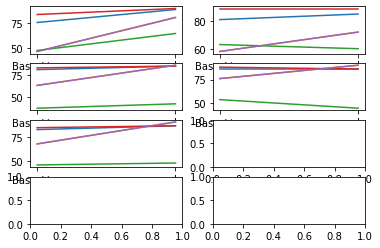

In [92]:
plot_model_iterations(scores_df)

In [77]:
# testing for function above
plot_model_iterations(scores_df)

,Model Name,Model Iteration,True Negative,False Positive,False Negative,True Positive,Accuracy,Precision-Closed,Recall-Closed,Precision-Open,Recall-Open
0,Logistic,Base_Line,22,24,25,130,76.0,47.0,48.0,84.0,84.0
1,Tree,Base_Line,29,17,21,134,81.0,58.0,63.0,89.0,86.0
2,KNN,Base_Line,17,29,10,145,81.0,63.0,37.0,83.0,94.0
3,Forest,Base_Line,25,21,8,147,86.0,76.0,54.0,88.0,95.0
4,SVM,Base_Line,21,25,10,145,83.0,68.0,46.0,85.0,94.0
0,Logistic,I,39,21,9,193,89.0,81.0,65.0,90.0,96.0
1,Tree,I,36,24,14,188,85.0,72.0,60.0,89.0,93.0
2,KNN,I,25,35,4,198,85.0,86.0,42.0,85.0,98.0
3,Forest,I,27,33,3,199,86.0,90.0,45.0,86.0,99.0
4,SVM,I,29,31,3,199,87.0,91.0,48.0,87.0,99.0


In [62]:
# logistic
y_pred = logmod.predict(X_test_scaled)
scores.append(np.ravel(confusion_matrix(y_test, y_pred)))

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 39  21]
 [  9 193]]
              precision    recall  f1-score   support

         0.0       0.81      0.65      0.72        60
         1.0       0.90      0.96      0.93       202

    accuracy                           0.89       262
   macro avg       0.86      0.80      0.83       262
weighted avg       0.88      0.89      0.88       262



In [61]:
# decision tree
y_pred = tree.predict(X_test)
scores.append(np.ravel(confusion_matrix(y_test, y_pred)))

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 36  24]
 [ 14 188]]
              precision    recall  f1-score   support

         0.0       0.72      0.60      0.65        60
         1.0       0.89      0.93      0.91       202

    accuracy                           0.85       262
   macro avg       0.80      0.77      0.78       262
weighted avg       0.85      0.85      0.85       262



In [60]:
# knn
y_pred = knn.predict(X_test_scaled)
scores.append(np.ravel(confusion_matrix(y_test, y_pred)))

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 25  35]
 [  4 198]]
              precision    recall  f1-score   support

         0.0       0.86      0.42      0.56        60
         1.0       0.85      0.98      0.91       202

    accuracy                           0.85       262
   macro avg       0.86      0.70      0.74       262
weighted avg       0.85      0.85      0.83       262



In [58]:
# random forest
y_pred = random_forest.predict(X_test)
scores.append(np.ravel(confusion_matrix(y_test, y_pred)))

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 27  33]
 [  3 199]]
              precision    recall  f1-score   support

         0.0       0.90      0.45      0.60        60
         1.0       0.86      0.99      0.92       202

    accuracy                           0.86       262
   macro avg       0.88      0.72      0.76       262
weighted avg       0.87      0.86      0.84       262



In [59]:
# svm
y_pred = svm.predict(X_test_scaled)
scores.append(np.ravel(confusion_matrix(y_test, y_pred)))

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[ 29  31]
 [  3 199]]
              precision    recall  f1-score   support

         0.0       0.91      0.48      0.63        60
         1.0       0.87      0.99      0.92       202

    accuracy                           0.87       262
   macro avg       0.89      0.73      0.78       262
weighted avg       0.87      0.87      0.85       262

